<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/Apples_version2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
base_dir = '/content/gdrive/My Drive/'

In [0]:
#REQUIREMENTS 
!Flask==0.11.1
!attrdict==2.0.0
!eventlet==0.19.0
!numpy==1.13.1
!scipy==0.19.1
!keras==2.0.8
!tensorflow==1.3.0
!h5py==2.6.0
!pandas==0.24.2
!Pillow==2.8.0

In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps


class ObjectDetector:

    def __init__(self,location_path = base_dir, graph_filename = 'frozen_inference_graph.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()

    def get_objects(self, image, probability_level):
        output_dict = self.run_inference_for_single_image(image)
        #return self.extract_image_from_boxes(image, output_dict,probability_level)
        return output_dict, self.extract_image_from_boxes(image, output_dict,probability_level)

        #return self.overlay_bounding_boxes(image, output_dict,probability_level)

    def run_inference_for_single_image(self, image, show_stats = True ):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?

        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') 
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                #draw rectanlge around object having this here interferes with later on as cropped images have rectanlge over writes
                #cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        #return image 
        return image, tf_boxes , output_images

# and \
                #box_ratio >= 0.75:               #box_width > 21               #box_height > 20 

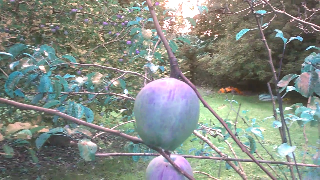

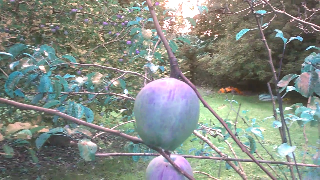

In [34]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.04)
#After processing
#cv2_imshow(final_image)
cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


In [20]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
#from keras.backend import tf as ktf
from keras.backend import tensorflow_backend as ktf

#from pathlib2 import Path  # python 2 backport #didn't like this in colab
from pathlib import Path

from os import listdir
from os.path import isfile, join

#traffic_light_colors = ['red', 'yellow', 'green', 'unknown']
apple_type = ['ripe', 'not_ripe']
apple_type_categories = [[1,0], [0,1]]

RESIZED_DIR = base_dir + 'data/' + 'Ripe_not_ripe/' + 'images_resized/'

def read_images(images_path):
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        print( 'root: ' , root , 'dirs: ' , dirs , 'files:' , files )
        #path = os.path.dirname(RESIZED_DIR + root + '/')
        path = os.path.dirname(images_path + 'images_resized/')
        #print("line 42")
        Path(path).mkdir(exist_ok=True)
        print("line 45")
        for filename in files:
            added = False
            print('line 48')
            for index, color in enumerate(apple_type):
                print('line 50')
                #if below removed
                #if filename.find(color) != -1: #my files are not ripe or not_ripe but camera files names
                
                labels.append(apple_type_categories[index])
                print('line 55')
                print(filename)
                #No such file or directory: '/content/gdrive/My Drive/data/Ripe_not_ripe/DSCF4576.JPG'
                #img = load_img(root + '/' + filename)  # this is a PIL image
                print(images_path + apple_type[index]+ '/' + filename)
                img = load_img(images_path + apple_type[index]+ '/' + filename)
                img = crop_image(img)
                print('line 62')
                #img.save('{}{}{}.jpeg'.format(RESIZED_DIR, root + '/', remove_ext(filename)), 'JPEG')
                #img.save('{}{}{}.jpeg'.format(RESIZED_DIR,  apple_type[index]+ '/' ,remove_ext(filename)), 'JPEG')
                img.save('{}{}{}'.format(RESIZED_DIR,  apple_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
                features.append(x)

                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
  #(base_dir + 'data/' + 'Ripe_not_ripe/')
    if not os.path.exists(images_path + 'preprocessed/' + 'ripe/' ):
      os.makedirs(images_path + 'preprocessed/' + 'ripe/' )
  
    for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'ripe/' + filename)


    if not os.path.exists(images_path + 'preprocessed/' + 'not_ripe/' ):
      os.mkdir(images_path + 'preprocessed/' + 'not_ripe/' )

    for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
      for filename in files:
        img = load_img(images_path + 'not_ripe/' + filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed/' + 'not_ripe/' + filename)


def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path+'ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      #labels.append('ripe')
      #apple_type_categories = [[1,0], [0,1]]
      labels.append(apple_type_categories[0])


  for root, dirs, files in os.walk(images_path+'not_ripe/', topdown=True):    
    for filename in files:
      img = load_img(images_path + 'not_ripe/' + filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      #labels.append('not_ripe')
      #apple_type_categories = [[1,0], [0,1]]
      labels.append(apple_type_categories[1])
     


  return np.array(features), np.array(labels)




def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img


#features, labels = read_images('images')
#features, labels = read_images(base_dir + 'data/' + 'Ripe_not_ripe/')

#preprocess_images(base_dir + 'data/' + 'Ripe_not_ripe/')

features, labels = load_prepared_images(base_dir + 'data/' + 'Ripe_not_ripe/' + 'preprocessed/')


train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

#model.add(layers.Dense(units=4, activation = 'softmax'))
model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])

# EPOCHS = 10
# BATCH_SIZE = 128

# X_train, y_train = train['features'], train['labels']
# X_validation, y_validation = validation['features'], validation['labels']

# train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
# validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

# print('# of training images:', train['features'].shape[0])
# print('# of validation images:', validation['features'].shape[0])

# steps_per_epoch = X_train.shape[0]//BATCH_SIZE
# validation_steps = X_validation.shape[0]//BATCH_SIZE

# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
# model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
#                     validation_data=validation_generator, validation_steps=validation_steps,
#                     shuffle=True, callbacks=[tensorboard])

score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#model.save('model/model.h5')
model.save(base_dir + 'apple_lenet_model.h5')

Using TensorFlow backend.


# of training images: 243
# of test images: 13
   Label  Count
0      0    243
1      1    243
# of training images: 194
# of validation images: 49
(256, 32, 32, 3)
(256, 2)
Updated Image Shape: (32, 32, 3)




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 6)         168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 6, 6, 16)          0         
_________________________________________

In [24]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os

class_model = load_model(base_dir + 'apple_lenet_model.h5')

traffic_light_colors = ['ripe', 'not_ripe']

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def predict(image_name):

    img = load_img(image_name, False, target_size=(32, 32))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = class_model.predict_classes(x)
    prob = class_model.predict_proba(x)

    return preds[0], prob[0]

def predict_for_detected(image_name):
   
    resized_image = image_name.resize((32,32), resample=0)

    x = img_to_array(resized_image)
    x = np.expand_dims(x, axis=0)
    preds = class_model.predict_classes(x)
    prob = class_model.predict_proba(x)

    return preds[0], prob[0]

total = 0
errors = 0
'''
for root, dirs, files in os.walk( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/', topdown=False):
    for filename in files:
        start = time.time()
        pred, prob = predict( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)
 
        elapsed = time.time() - start
        print(filename, ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')
        total += 1
       
        img=mpimg.imread( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)
        imgplot = plt.imshow(img)
        plt.show()
        #if filename.find(traffic_light_colors[pred]) == -1:
        if traffic_light_colors[pred] ==  'not_ripe':
            print('not correct')
            errors += 1
            
        else:
            print('correct')

print('errors: {} ({} %) out of {}'.format(errors, 100 * errors / total, total))
'''

"\nfor root, dirs, files in os.walk( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/', topdown=False):\n    for filename in files:\n        start = time.time()\n        pred, prob = predict( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)\n \n        elapsed = time.time() - start\n        print(filename, ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')\n        total += 1\n       \n        img=mpimg.imread( base_dir + 'data/Ripe_not_ripe/preprocessed/ripe/' + filename)\n        imgplot = plt.imshow(img)\n        plt.show()\n        #if filename.find(traffic_light_colors[pred]) == -1:\n        if traffic_light_colors[pred] ==  'not_ripe':\n            print('not correct')\n            errors += 1\n            \n        else:\n            print('correct')\n\nprint('errors: {} ({} %) out of {}'.format(errors, 100 * errors / total, total))\n"

final_image.shape :  (720, 1280, 3)


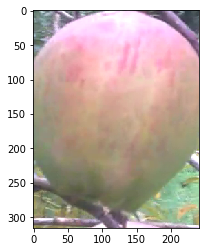

Result:  : ripe - prodb: [0.58945584 0.41054416] -elapsed time: 0.0056765079498291016  s
height, width =  (241, 316)
ymin, xmin, ymax, xmax 0.432986319065094 0.4265681505203247 0.8715772032737732 0.6153335571289062
ymin, xmin, ymax, xmax 311 546 627 787


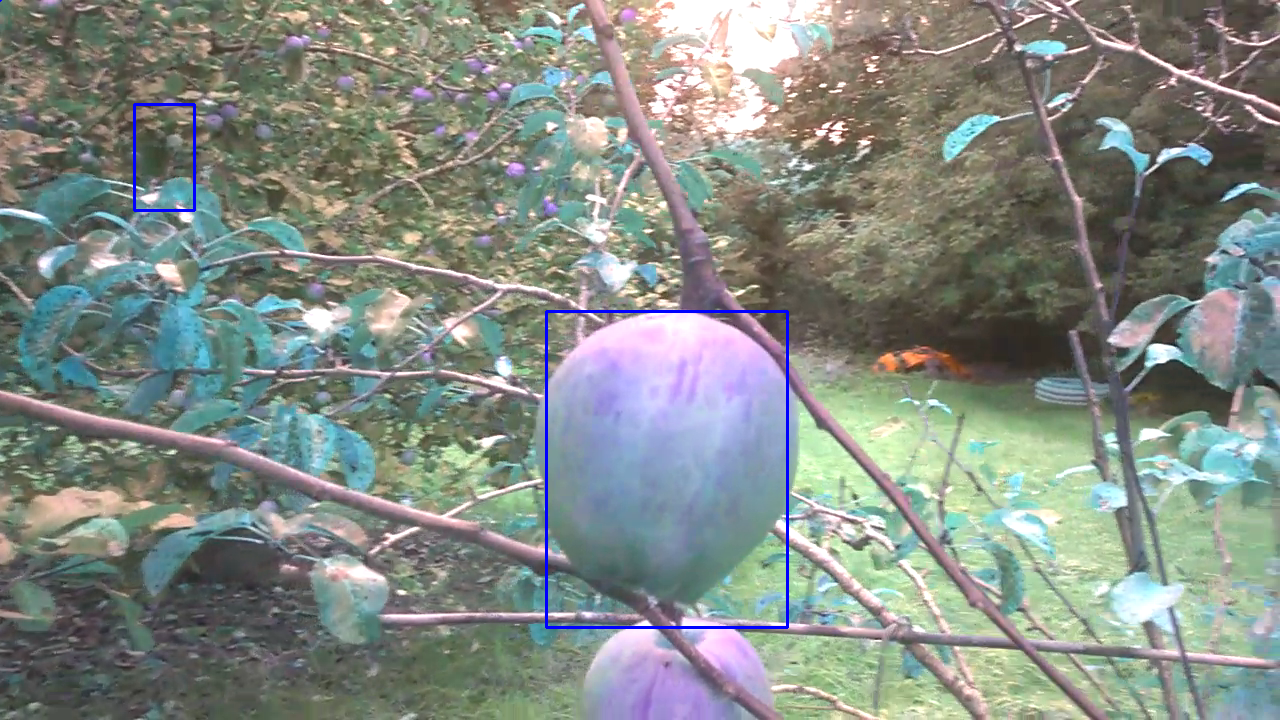

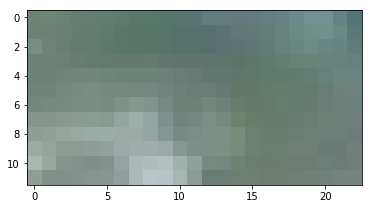

Result:  : not_ripe - prodb: [1.2459584e-09 1.0000000e+00] -elapsed time: 0.0056765079498291016  s


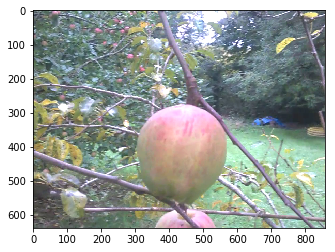

Result:  : not_ripe - prodb: [2.1574217e-06 9.9999785e-01] -elapsed time: 0.0056765079498291016  s


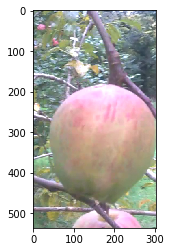

Result:  : not_ripe - prodb: [1.5422331e-04 9.9984574e-01] -elapsed time: 0.0056765079498291016  s


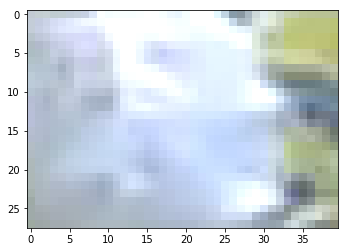

Result:  : not_ripe - prodb: [3.5301113e-08 1.0000000e+00] -elapsed time: 0.0056765079498291016  s


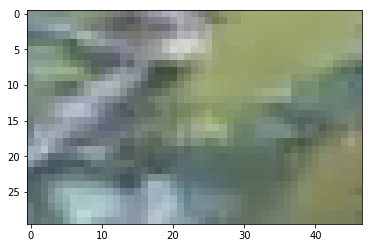

Result:  : not_ripe - prodb: [6.097855e-06 9.999939e-01] -elapsed time: 0.0056765079498291016  s


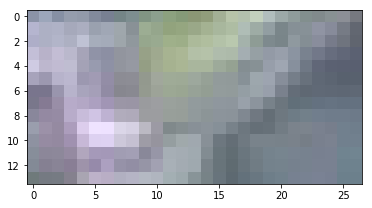

Result:  : not_ripe - prodb: [1.07701046e-04 9.99892235e-01] -elapsed time: 0.0056765079498291016  s


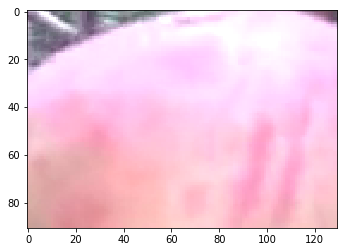

Result:  : not_ripe - prodb: [1.845949e-04 9.998154e-01] -elapsed time: 0.0056765079498291016  s


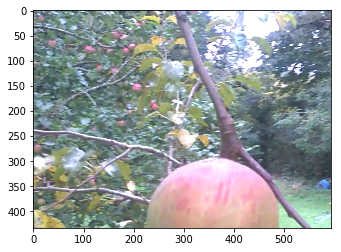

Result:  : not_ripe - prodb: [3.9796467e-07 9.9999964e-01] -elapsed time: 0.0056765079498291016  s


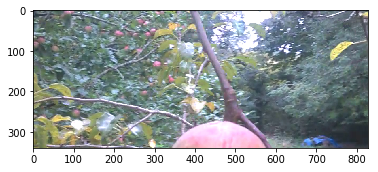

Result:  : not_ripe - prodb: [6.3912998e-06 9.9999356e-01] -elapsed time: 0.0056765079498291016  s


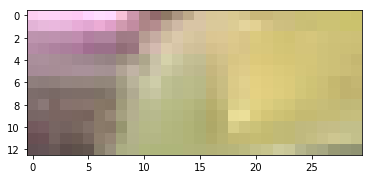

Result:  : not_ripe - prodb: [1.7208648e-04 9.9982786e-01] -elapsed time: 0.0056765079498291016  s


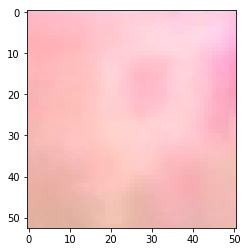

Result:  : not_ripe - prodb: [1.1294666e-04 9.9988699e-01] -elapsed time: 0.0056765079498291016  s


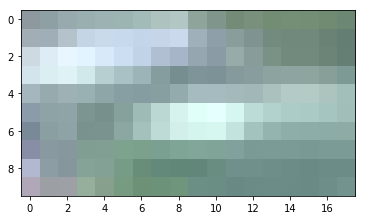

Result:  : not_ripe - prodb: [1.7048333e-06 9.9999833e-01] -elapsed time: 0.0056765079498291016  s


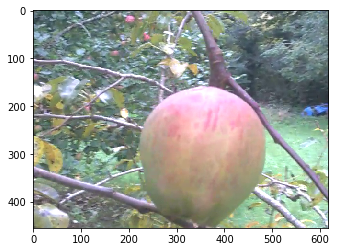

Result:  : not_ripe - prodb: [2.4848534e-06 9.9999750e-01] -elapsed time: 0.0056765079498291016  s


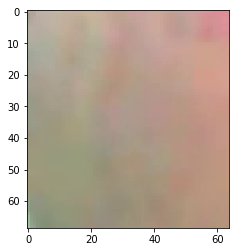

Result:  : not_ripe - prodb: [0.01492154 0.98507845] -elapsed time: 0.0056765079498291016  s


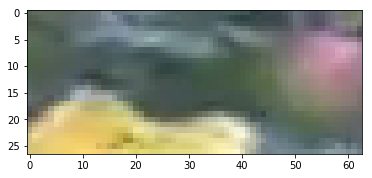

Result:  : not_ripe - prodb: [1.1290291e-07 9.9999988e-01] -elapsed time: 0.0056765079498291016  s


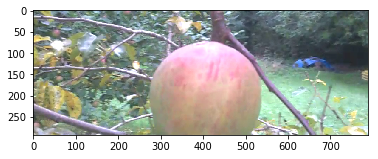

Result:  : not_ripe - prodb: [3.2461978e-07 9.9999964e-01] -elapsed time: 0.0056765079498291016  s


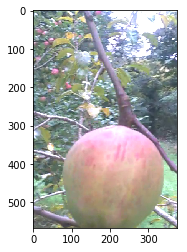

Result:  : not_ripe - prodb: [7.7969198e-06 9.9999225e-01] -elapsed time: 0.0056765079498291016  s


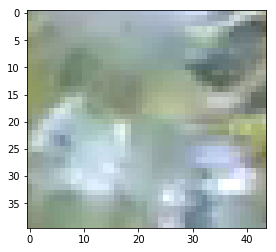

Result:  : not_ripe - prodb: [5.316982e-07 9.999995e-01] -elapsed time: 0.0056765079498291016  s


In [64]:

#height, width = object_images[i].size #  as per PIL
height, width ,_ = final_image.shape #  as per PIL
print('final_image.shape : ', final_image.shape)

#for   data , image in object_data, object_images :
for   i in  range(0, len(object_images ) ) :
  pred, prob = predict_for_detected( object_images[i])
  #imgplot = plt.imshow(object_images[i])
  plt.imshow(object_images[i])
  plt.show()
  print('Result: ', ':', traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')
  if pred == 0 :
    #boxes = object_data['detection_boxes']
    #height, width, _ = object_images[i].shape #this worked above when it was a tensor
    #height, width = object_images[i].size #  as per PIL
    print('height, width = ', object_images[i].size)
    ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
    print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
    ymin = int(ymin * height)
    ymax = int(ymax * height)
    xmin = int(xmin * width)
    xmax = int(xmax * width)

    print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

    cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
    cv2_imshow(final_image)

